In [1]:
import numpy as np

In [2]:
def loadDataSet(filename):
    dataMat = []
    labelMat = []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = line.strip().split()
        #将每一行的两个特征x1，x2，加上x0=1,组成列表并添加到数据集列表中
        dataMat.append([1.0]+[float(arr) for arr in lineArr[0:-1]])
        labelMat.append(int(lineArr[-1]))
    return dataMat,labelMat

In [3]:
# test
dataMat, labelMat = loadDataSet("C:\\Users\\ms\\Desktop\\machinelearninginaction\\Ch05\\testSet.txt")
dataMat[0:5]

[[1.0, -0.017612, 14.053064],
 [1.0, -1.395634, 4.662541],
 [1.0, -0.752157, 6.53862],
 [1.0, -1.322371, 7.152853],
 [1.0, 0.423363, 11.054677]]

## 使用批量梯度上升找到最佳参数

In [4]:
def sigmoid(inX):
    return 1.0/(1+np.exp(-inX))

In [8]:
# 批量梯度上升算法
def batchGradAscent(dataMatIn, classLabels):
    dataMatrix = np.mat(dataMatIn)   #convert to NumPy matrix
    # convert to NumPy matrix
    labelMat = np.mat(classLabels).transpose()  # 转换数组的维度,行向量转换为列向量
    m,n = np.shape(dataMatrix)
    alpha = 0.001  # 步长
    maxCycles = 500  # 迭代次数
    # n x 1为数组
    weights = np.ones((n,1)) # n维列向量
    for k in range(maxCycles):              #heavy on matrix operations
        #计算所有数据的分类概率，h是m维向量,这里实际上进行了m*n次乘法运算
        h = sigmoid(dataMatrix*weights)     #matrix mult 算法的预测
        error = (labelMat - h)              #vector subtraction
        gradient = dataMatrix.transpose() * error # 计算梯度
        weights = weights + alpha * gradient #matrix mult
    return weights

In [49]:
BGAweights = gradAscent(dataMat,labelMat)
BGAweights

matrix([[ 4.12414349],
        [ 0.48007329],
        [-0.6168482 ]])

## 分析数据：画出决策边界

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

In [105]:
def plotBestFit(dataMat,labelMat,weights):
    """
    :param weights:必须是np.mat()类型（matrix）
    """
    import matplotlib.pyplot as plt
    dataArr = np.array(dataMat)
    n = np.shape(dataArr)[0]
    xcord1 = []; ycord1 = []
    xcord2 = []; ycord2 = []
    for i in range(n):
        if int(labelMat[i])== 1:
            xcord1.append(dataArr[i,1])
            ycord1.append(dataArr[i,2])
        else:
            xcord2.append(dataArr[i,1])
            ycord2.append(dataArr[i,2])
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(xcord1, ycord1, s=30, c='red', marker='s')
    ax.scatter(xcord2, ycord2, s=30, c='green')
    # min_x = np.mat(dataMat)[:, 1].min()
    # max_x = np.mat(dataMat)[:, 2].max()
    # y_min_x = (-weights[0] - weights[1] * min_x) / weights[2]
    # y_max_x = (-weights[0] - weights[1] * max_x) / weights[2]  # here, sigmoid(wx = 0) so wo + w1*x1 + w2*x2 = 0
    # plt.plot([min_x, max_x], [y_min_x[0, 0], y_max_x[0, 0]], '-g')
    
    x = np.arange(-3.0,3.0,0.1)
    y = np.array( (-weights[0] - weights[1]*x) / weights[2])[0]
    ax.plot(x,y)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()

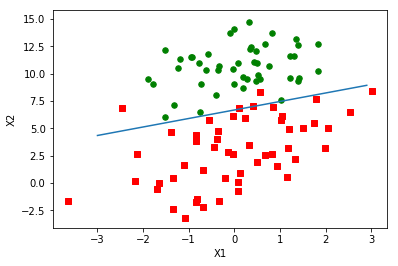

In [106]:
plotBestFit(dataMat,labelMat,BGAweights)

## 随机梯度上升算法

随机梯度上升算法与梯度上升算法在代码上很相似，但也有一些区别：1、梯度算法的变量h和误差error都是向量，而随机梯度的全是数值；2、随机梯度没有矩阵的转换过程，所有的变量类型都是numpy数组。

In [164]:
def stocGradAscent0(dataMatrix, classLabels):
    m,n = np.shape(dataMatrix)
    alpha = 0.01
    # 1 x n维数组
    weights = np.ones(n)   #initialize to all ones
    for i in range(m):
        h = sigmoid(sum(dataMatrix[i]*weights))
        error = classLabels[i] - h #误差
        stocGrad =  error * dataMatrix[i] # 随机梯度
        weights = weights + alpha * stocGrad
    return weights

In [166]:
# dataMat是列表，error是float，两者不能相乘，需要将列表转换为array类型
# 为调用plotBestFit画图，需要将weights转换成列向量
SGAweights0 = np.mat(stocGradAscent0(np.array(dataMat),labelMat)).transpose()
SGAweights0

matrix([[ 1.01702007],
        [ 0.85914348],
        [-0.36579921]])

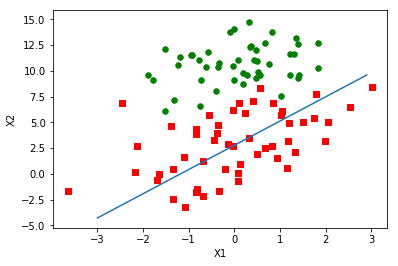

In [141]:
plotBestFit(dataMat,labelMat,SGAweights0)

拟合后，分类器错分了三分之一的样本

### 改进的随机梯度上升算法

In [168]:
def stocGradAscent1(dataMatrix, classLabels, numIter=150):
    m,n = np.shape(dataMatrix)
    weights = np.ones(n)   #initialize to all ones
    for j in range(numIter):
        dataIndex = list(range(m))
        for i in range(m):
            # alpha每次迭代时都调整,随迭代次数不断减小，但永远不会减小到0,解决局部波动
            # 保证在多次迭代后新数据仍具有一定的影响
            alpha = 4/(1.0+j+i)+0.0001    #apha decreases with iteration, does not 
            # 随机选取样本更新回归系数
            randIndex = int(np.random.uniform(0,len(dataIndex)))#go to 0 because of the constant
            h = sigmoid(sum(dataMatrix[randIndex]*weights))
            error = classLabels[randIndex] - h
            weights = weights + alpha * error * dataMatrix[randIndex]
            # 使用完后删除随机选取的值
            del(dataIndex[randIndex]) #必选把range对象转换为list，不能删除range对象
    return weights

In [170]:
SGAweights1 = np.mat(stocGradAscent1(np.array(dataMat),labelMat)).transpose()
SGAweights1

matrix([[14.54927401],
        [ 1.12781549],
        [-1.97381997]])

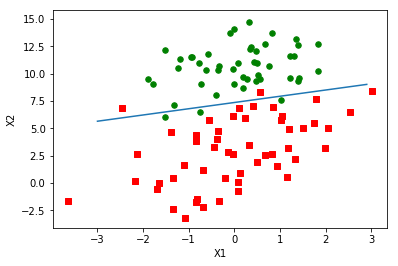

In [171]:
plotBestFit(dataMat,labelMat,SGAweights1)

## 牛顿法

In [176]:
 '''
 functuion: 牛顿法更新theta（θ）,计算海森矩阵
 note: 这里一定要对 XT*X 结果求逆，不然分类效果无法直视
 '''
 def computeHessianMatrix(dataMatrix):
     hessianMatrix = np.mat(dataMatrix).transpose().dot(np.mat(dataMatrix))
     return hessianMatrix.I #矩阵求逆

In [177]:
'''
function: 牛顿法更新theta
'''
def newtonMethod(dataMat, labelMat, numIter = 150):
    m,n = np.shape(dataMat)
    dataMatrix = np.mat(dataMat)
    labelMat = np.mat(labelMat).transpose()
    weights = np.ones((n,1)) #参数向量
    hessianMatrix = computeHessianMatrix(dataMatrix)
    #print('shape of hessian', shape(hessianMatrix))
    for k in range(numIter):
        h = sigmoid(dataMatrix * weights)
        error = (labelMat - h)
        weights = weights - (dataMatrix*hessianMatrix).transpose() * error 
    return weights

In [178]:
NTweights = newtonMethod(dataMat,labelMat)
NTweights

matrix([[-163.75559123],
        [ -15.63335665],
        [  28.52015042]])

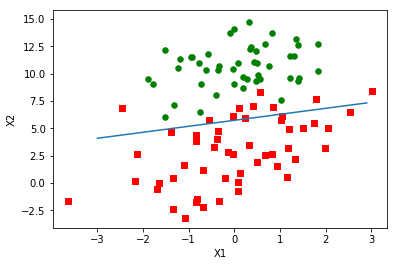

In [179]:
plotBestFit(dataMat,labelMat,NTweights)

__________________

## 预测示例：从疝气病症预测病马的死亡率

数据包含368个样本和28个特征，有30%的值是缺失的。  
需要对数据集进行预处理，使其可以顺利的使用分类算法。在预处理阶段需要做两件事：1、多有的缺失值必须用一个实数替换，因为我们使用的numpy数据类型不允许包含缺失值。这里选择实数0来替换所有缺失值，恰好能适用于logistic回归。选择0的原因是我们需要的是一个在更新时不会影响系数的值。回归系数的更新公式为：   
weights = weights + alpha * error * dataMatrix[randIndex]  
如果dataMatrix的某特征对应值为0，那么该特征的系数将不会更新，即：  
weights = weights  
另外，由于sigmoid(0)=0.5，即它对结果的预测不会有任何倾向性，因此上述做法也不会对误差项造成任何影响。  
预处理中做的第二件事是，如果在测试数据集中发现一条数据的类别标签已经缺失，那么我们的简单做法是将该数据丢弃。这是因为类别标签与特征不同，很难确定采用哪个合适的值来替换。采用logistic回归进行分类时这种做法是合理的，而如果采用类似KNN的方法就可能不行。

## 测试算法：用Logistic回归进行分类

使用logistic回归方法进行分类，所需做的是把测试集上每个特征向量乘以最优化方法得来的回归系数，再将该乘积结果求和，最后输入到sigmoid函数中即可。如果对应的sigmoid值大于0.5就预测类别标签为1，否则为0


In [180]:
def classifyVector(inX, weights):
    prob = sigmoid(sum(inX*weights))
    if prob > 0.5:
        return 1.0
    else:
        return 0.0

In [181]:
def colicTest():
    """
    打开测试集和训练集，并对数据进行格式化处理。
    数据最初有三个类别标签，分别代表马的三种情况：仍存活、已经死亡和已经安乐死。
    为了方便将已经死亡和已经安乐死合并为’未能存活‘标签（只有0和1两个值）
    :return:
    """
    frTrain = open('C:\\Users\ms\Desktop\machinelearninginaction\Ch05\horseColicTraining.txt')
    frTest = open('C:\\Users\ms\Desktop\machinelearninginaction\Ch05\horseColicTest.txt')
    trainingSet = []
    trainingLabels = []
    for line in frTrain.readlines():
        currLine = line.strip().split('\t')
        lineArr =[]
        for i in range(21):
            lineArr.append(float(currLine[i]))
        trainingSet.append(lineArr)
        trainingLabels.append(float(currLine[21]))
    # 计算回归系数向量
    trainWeights = stocGradAscent1(np.array(trainingSet), trainingLabels, 1000)
    errorCount = 0
    numTestVec = 0.0
    # 导入测试集并计算分类错误率
    for line in frTest.readlines():
        numTestVec += 1.0
        currLine = line.strip().split('\t')
        lineArr =[]
        for i in range(21):
            lineArr.append(float(currLine[i]))
        if int(classifyVector(np.array(lineArr), trainWeights))!= int(currLine[21]):
            errorCount += 1
    errorRate = (float(errorCount)/numTestVec)
    print ("the error rate of this test is: %f" % errorRate)
    return errorRate

In [182]:
def multiTest():
    """
    调用colicTest()函数10次并求结果的平均值
    :return:
    """
    numTests = 10
    errorSum=0.0
    for k in range(numTests):
        errorSum += colicTest()
    print ("after %d iterations the average error rate is: %f" % (numTests, errorSum/float(numTests)))

In [183]:
multiTest()

the error rate of this test is: 0.268657
the error rate of this test is: 0.417910
the error rate of this test is: 0.417910
the error rate of this test is: 0.343284
the error rate of this test is: 0.328358
the error rate of this test is: 0.328358
the error rate of this test is: 0.313433
the error rate of this test is: 0.358209
the error rate of this test is: 0.388060
the error rate of this test is: 0.298507
after 10 iterations the average error rate is: 0.346269


从结果看,10次迭代之后的平均错误率为35%。事实上这个结果并不差，因为有30%的数据缺失。当然，可以调整colicTest()zhon